### Version 3

Cette seconde version traite les images en Gray Scale comme la V2 et ajoute une implémentation avec VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Unzip the OCT Archive folder
Unrar / Unzip the dataset.

In [ ]:
# install the needed packages to unzip rar
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 2.9MB/s 


In [ ]:
DATASET_RAR_FILE = '/content/gdrive/MyDrive/OCT2017.rar'
from pyunpack import Archive
print('Archive extraction in Progres...')
Archive(DATASET_RAR_FILE).extractall('.')
print('Archive extraction done!')

Archive extraction in Progres...
Archive extraction done!


In [ ]:
import io
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from math import floor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# évaluation
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# architecture deep learning
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, InputLayer, Input
from keras.utils import np_utils

# métrique deep learning
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# transfer learning et extraction de feature
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import preprocess_input

# estimateur pour classification 
from xgboost import XGBClassifier

# Pour ignorer les warning
import warnings
warnings.filterwarnings("ignore")

# Constants
DATASET_PATH = './OCT2017'
DATASET_TRAIN_PATH = DATASET_PATH + '/train'
TOMOGRAPHY_TYPES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
DEFAULT_IMAGE_RESIZE = (256, 256)
IMAGE_SHAPE = [256, 256, 1]

### Create output folders

In [ ]:
# CNN, LeNet and EfficientNetB5
FOLDER_CNN = "./CNN"
FOLDER_LE_NET = "./LeNet"
FOLDER_EFFICIENT_NET_B5 = "./EfficientNetB5"
FOLDER_VGG16 = "./VGG16"
FOLDERS = [FOLDER_CNN, FOLDER_LE_NET, FOLDER_EFFICIENT_NET_B5, FOLDER_VGG16]
for folder in FOLDERS:
  if not os.path.exists(folder):
    os.makedirs(folder)

# Data Visualization

### Tomography Type Distribution

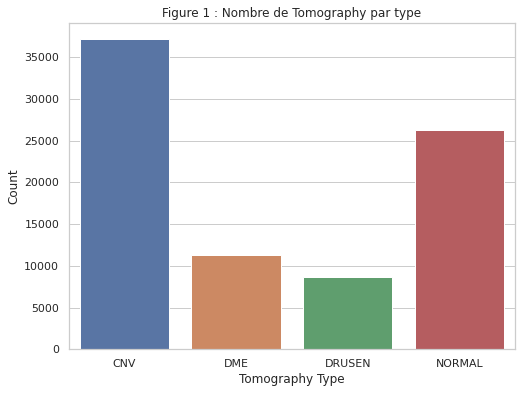

In [ ]:
number_of_images = []
for tomo_type in TOMOGRAPHY_TYPES:
    path = f'{DATASET_TRAIN_PATH}/{tomo_type}'
    number_of_images.append(len(os.listdir(path)))
dictionary = {'Tomography Type': TOMOGRAPHY_TYPES , 'Count': number_of_images}
df = pd.DataFrame(dictionary)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="Tomography Type", y="Count", data=df)
ax.set_title("Figure 1 : Nombre de Tomography par type")
plt.show()

### Observations:
- Training Dataset is Imbalanced

# Modeling


In [ ]:
"""
  Reads the images of the given folder name. It returns a Data Frame representation. 
"""
def read_data_folder(name):
  folder_path = f'{DATASET_PATH}/{name}'
  print(f'Read images of folder {folder_path}')
  data = {'Image Path': [], 'Type': [], 'X': [], 'Y': [], 'Z': []}
  for tomo_type in TOMOGRAPHY_TYPES:
    path = f'{folder_path}/{tomo_type}'
    print(f'Read images of sub folder {path}')
    paths = glob.glob(f'{path}/*')
    for p in paths:
      data['Image Path'].append(p)
      data['Type'].append(tomo_type)
      tomography = plt.imread(p)
      shape = tomography.shape
      data['X'].append(shape[0])
      if len(shape) >= 2:
        data['Y'].append(shape[1])
      else:
         data['Y'].append(0)
      if len(shape) == 3:
        data['Z'].append(shape[2])
      else:
        data['Z'].append(0)
  print(f'Read images of folder {folder_path}. Done!')
  return pd.DataFrame(data)

In [ ]:
"""
  Resize the images
"""
def resize_image(path, resize=DEFAULT_IMAGE_RESIZE, reshape=True):
  image = plt.imread(path, cv2.IMREAD_GRAYSCALE)
  # make the resize
  image = cv2.resize(image, dsize = resize)
  if reshape:
    image=image.reshape(256, 256, 1)
  return image

In [ ]:
# Get the train data set
df_train = read_data_folder('train')

Read images of folder ./OCT2017/train
Read images of sub folder ./OCT2017/train/CNV
Read images of sub folder ./OCT2017/train/DME
Read images of sub folder ./OCT2017/train/DRUSEN
Read images of sub folder ./OCT2017/train/NORMAL
Read images of folder ./OCT2017/train. Done!


In [ ]:
df_train.head(6)

,Image Path,Type,X,Y,Z
0,./OCT2017/train/CNV/CNV-5603164-42.jpeg,CNV,496,1536,0
1,./OCT2017/train/CNV/CNV-6106345-78.jpeg,CNV,496,512,0
2,./OCT2017/train/CNV/CNV-4155829-1.jpeg,CNV,496,512,0
3,./OCT2017/train/CNV/CNV-9238054-20.jpeg,CNV,496,512,0
4,./OCT2017/train/CNV/CNV-1779025-41.jpeg,CNV,496,1536,0
5,./OCT2017/train/CNV/CNV-4283050-57.jpeg,CNV,496,512,0


In [ ]:
df_train.groupby(['X', 'Y', 'Z']).count()

Image Path   Type
X   Y    Z                   
496 384  0          16     16
    512  0       37892  37892
    768  0       21485  21485
    1024 0         274    274
    1536 0        8361   8361
512 512  0       15456  15456

In [ ]:
df_train.groupby(['X', 'Y', 'Z', 'Type']).count()

Image Path
X   Y    Z Type              
496 384  0 CNV             15
           NORMAL           1
    512  0 CNV          19912
           DME           1485
           DRUSEN        5371
           NORMAL       11124
    768  0 CNV          12050
           DME            816
           DRUSEN        2531
           NORMAL        6088
    1024 0 CNV            173
           DME             14
           DRUSEN          23
           NORMAL          64
    1536 0 CNV           5055
           DME            374
           DRUSEN         691
           NORMAL        2241
512 512  0 DME           8659
           NORMAL        6797

- Observation : It seems that the train dataset images are gray scale (Z equals zero). But we have various resolutions, we have to resize our images. We are going to resize our images and check if there is any impact.

### Impact of resizing

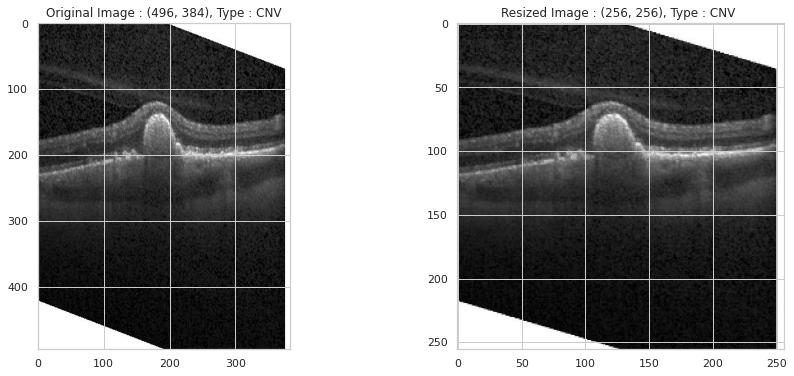

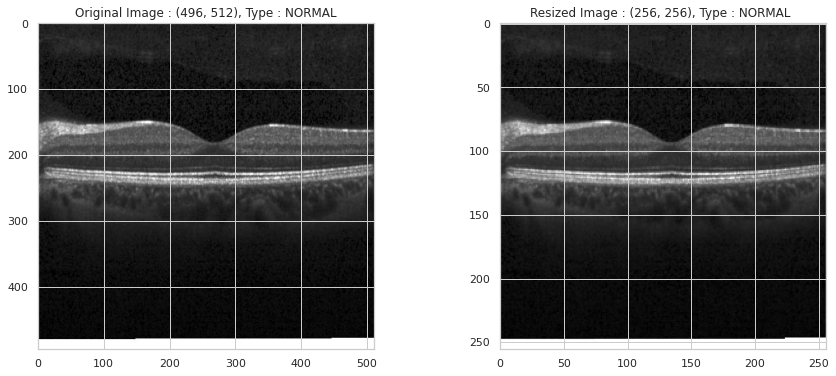

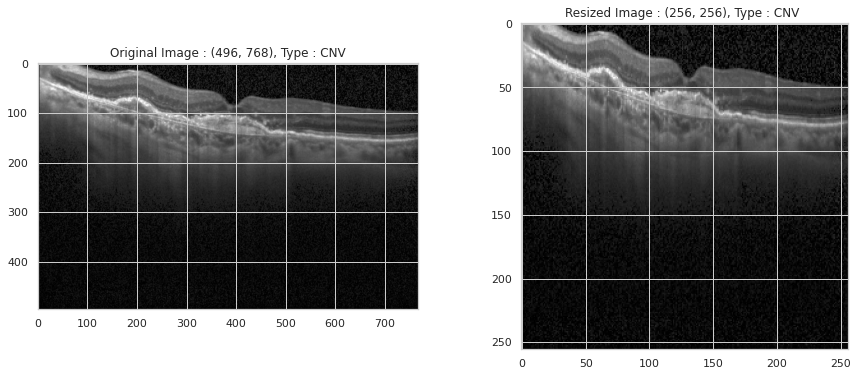

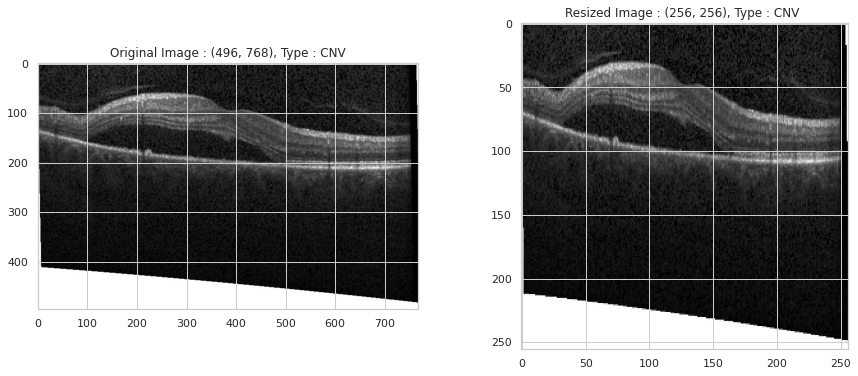

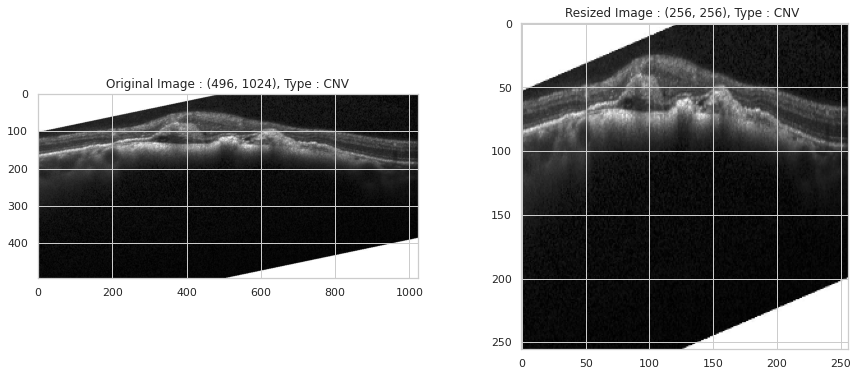

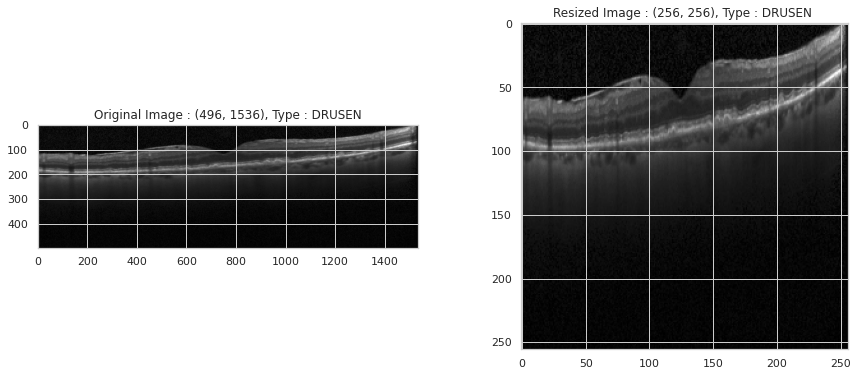

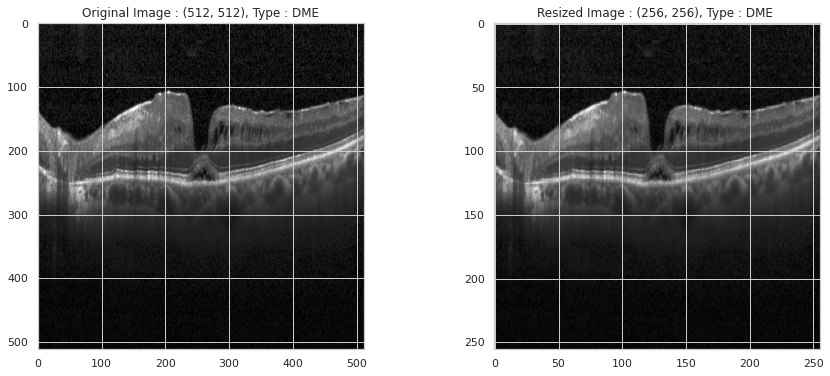

In [ ]:
# As remider to plot the images no need for reshaping
IMAGE_RESIZE = DEFAULT_IMAGE_RESIZE
RESOLUTIONS = [(496, 384), (496, 512), (496, 768), (496, 768), (496, 1024),(496, 1536), (512, 512)]
for resolution in RESOLUTIONS:
  # Filter data frame by resolution
  df_temp = df_train[(df_train['X'] == resolution[0]) & (df_train['Y'] == resolution[1])]
  # Take randomly one images
  df_temp = df_temp.sample(1)
  # Get its path and type
  path = df_temp['Image Path'].values[0]
  image_type = df_temp['Type'].values[0]
  
  plt.figure(figsize=(15, 6))

  # Plot original image
  plt.subplot(121)
  image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  plt.imshow(image, cmap='gray');
  plt.title(f'Original Image : {image.shape}, Type : {image_type}');

  # Plot resized image (512, 512)
  plt.subplot(122)
  image = resize_image(path, reshape=False)
  plt.imshow(image, cmap='gray');
  plt.title(f'Resized Image : {IMAGE_RESIZE}, Type : {image_type} ');

  plt.show()

# Models Architecture 

# Train / Validation dataset

### Train dataset 

In [ ]:
print(f'Train shape: {df_train.shape}')

Train shape: (83484, 5)


#### Create list with Train images


In [ ]:
X_train = [resize_image(df_train['Image Path'][index]) for index in range(df_train.shape[0])]
y_train = df_train["Type"]

In [ ]:
len(X_train)

83484

In [ ]:
X_train[0].shape

(256, 256, 1)

In [ ]:
len(y_train)

83484

### Validation dataset 

In [ ]:
# Get the validation data set
df_test = read_data_folder('test')

Read images of folder ./OCT2017/test
Read images of sub folder ./OCT2017/test/CNV
Read images of sub folder ./OCT2017/test/DME
Read images of sub folder ./OCT2017/test/DRUSEN
Read images of sub folder ./OCT2017/test/NORMAL
Read images of folder ./OCT2017/test. Done!


In [ ]:
print(f'Test shape {df_test.shape}')

Test shape (968, 5)


#### Create list with Test images


In [ ]:
X_test = [resize_image(df_test['Image Path'][index]) for index in range(df_test.shape[0])]
y_test = df_test["Type"]

In [ ]:
len(X_test)

968

In [ ]:
X_test[0].shape

(256, 256, 1)

### Encodage de la variable cible

In [ ]:
"""
Encode image label type 
"""
def encode_label(label):
  if label == 'CNV':
    return 0
  elif label == 'DME':
    return 1
  elif label == 'DRUSEN':
    return 2
  elif label == 'NORMAL':
    return 3
  else:
    return label

y_train = y_train.apply(lambda label:encode_label(label))
y_test = y_test.apply(lambda label:encode_label(label))

y_train_categorial = np_utils.to_categorical(y_train)
y_test_categorial = np_utils.to_categorical(y_test)

### Helper functions

##### Fonction d'export en fichier text

Cette fonction permet d'exporter le contenu text en un fichier de type txt

In [ ]:
def export_to_text_file(content, name, folder_destination):
    file = open(f'{folder_destination}/{name}.txt', "w")
    file.write(content)
    file.close()

##### Classification report

Cette fonction permet de récupérer le classificaiton report

In [ ]:
def classification(y_pred, y_test, folder_destination):
    report = classification_report(y_test, y_pred, target_names=TOMOGRAPHY_TYPES)
    export_to_text_file(report, 'classification_report', folder_destination)
    print(report)

##### Confusion matrix
Cette fonction permet l'affichage de la matrice de confusion

In [ ]:
def confusion(y_pred, y_test, folder_destination):
    cm=confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    plt.colorbar() 
    tick_marks = np.arange(len(TOMOGRAPHY_TYPES))
    plt.xticks(tick_marks, TOMOGRAPHY_TYPES)
    plt.yticks(tick_marks, TOMOGRAPHY_TYPES)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    
    plt.savefig(f'./{folder_destination}/confusion_matrix.png')

##### Courbes de précision et de perte
Cette fonction permet l'affichage des courbes de précision et de perte sur les données d'entrainement et les données de test.

In [ ]:
def precision_perte(history, folder_destination):
    
    train_acc = history.history["accuracy"]
    valid_acc = history.history["val_accuracy"]
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,len(train_acc)+1), train_acc)
    plt.plot(np.arange(1,len(train_acc)+1), valid_acc)
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training et Validation Accuracy")
    plt.grid()
    plt.xlim([1,len(train_acc)]);
    plt.xlabel("Epoch");
    
    plt.subplot(1,2,2)
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    plt.plot(np.arange(1,len(train_loss)+1), train_loss)
    plt.plot(np.arange(1,len(train_loss)+1), valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training et Validation loss")
    plt.grid()
    plt.xlim([1,len(train_loss)]);
    plt.xlabel("Epoch");
    
    plt.savefig(f'./{folder_destination}/loss_accuracy.png') 

##### Sauvgarde du Modèle

Cette fonction permet de sauvegarder notre modèle sur notre machine, elle exporte aussi le summary sous format de fichier

In [ ]:
def save_model(model, folder_destination):
    # Récuperer le contenu summary du modèle et le Stocker dans un fichier text
    stream = io.StringIO()
    # récupérer le contenu du summary dans la variable stream
    model.summary(print_fn=lambda x: stream.write(x + '\n'))
    # extraire le texte du stream
    summary = stream.getvalue()
    stream.close()
    export_to_text_file(summary, 'summary', folder_destination)
    
    # Stocker le modèle en local pour une utilisation ultérieur (Démo...)
    model.save(f'./{folder_destination}')

##### Fonction d'évaluation
Cette fonction permet la synthèse des 3 fonctions précédentes en permettant l'affichage du rapport de classifiaction, de la matrice de confusion, des courbes de précisions et de pertes.

In [ ]:
def evaluate(model, y_pred, y_test, history, folder_destination):
    classification(y_pred, y_test, folder_destination)
    confusion(y_pred,y_test, folder_destination)
    precision_perte(history, folder_destination)
    save_model(model, folder_destination)

## MODELISATION 1: CNN


In [ ]:
model = Sequential()

# couche de convolution
model.add(Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=[256, 256, 1]))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2, padding="same"))
model.add(Flatten())
model.add(Dropout(0.05))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

### Résumé du modèle

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)            

### Paramètrage de la métrique d'optimisation

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=6000, decay_rate=0.95, staircase=True)

### Compilation du modèle

In [ ]:
model.compile(optimizer=Adam(learning_rate = lr_schedule), loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [ ]:
# convert list to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
X_train.shape

(83484, 256, 256, 1)

In [ ]:
X_test.shape

(968, 256, 256, 1)

In [ ]:
y_train_categorial

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_test_categorial

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train_categorial, validation_data=(X_test, y_test_categorial), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2609/2609 [==============================] - 63s 18ms/step - loss: 2.2933 - accuracy: 0.5130 - val_loss: 1.4945 - val_accuracy: 0.4174
Epoch 2/10
2609/2609 [==============================] - 47s 18ms/step - loss: 1.0048 - accuracy: 0.5977 - val_loss: 1.4564 - val_accuracy: 0.4545
Epoch 3/10
2609/2609 [==============================] - 47s 18ms/step - loss: 0.5734 - accuracy: 0.7979 - val_loss: 0.8919 - val_accuracy: 0.6395
Epoch 4/10
2609/2609 [==============================] - 46s 18ms/step - loss: 0.3706 - accuracy: 0.8671 - val_loss: 0.7763 - val_accuracy: 0.7345
Epoch 5/10
2609/2609 [==============================] - 47s 18ms/step - loss: 0.2288 - accuracy: 0.9196 - val_loss: 0.4109 - val_accuracy: 0.8750
Epoch 6/10
2609/2609 [==============================] - 47s 18ms/step - loss: 0.1371 - accuracy: 0.9525 - val_loss: 0.5706 - val_accuracy: 0.8605
Epoch 7/10
2609/2609 [==============================] - 46s 18ms/step - loss: 0.0951 - accuracy: 0.9682 - val_loss: 0.5657 -

### Affichage et Export des résultats

              precision    recall  f1-score   support

         CNV       0.77      1.00      0.87       242
         DME       0.99      0.52      0.68       242
      DRUSEN       0.95      0.99      0.97       242
      NORMAL       0.88      0.99      0.93       242

    accuracy                           0.87       968
   macro avg       0.90      0.87      0.86       968
weighted avg       0.90      0.87      0.86       968

INFO:tensorflow:Assets written to: ././CNN/assets


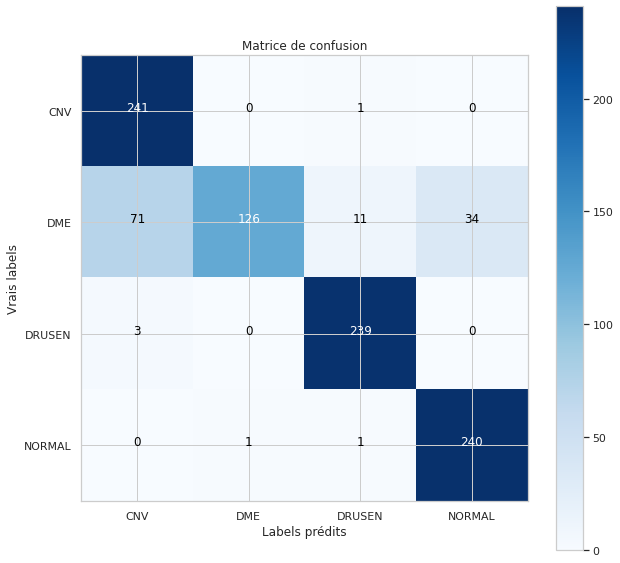

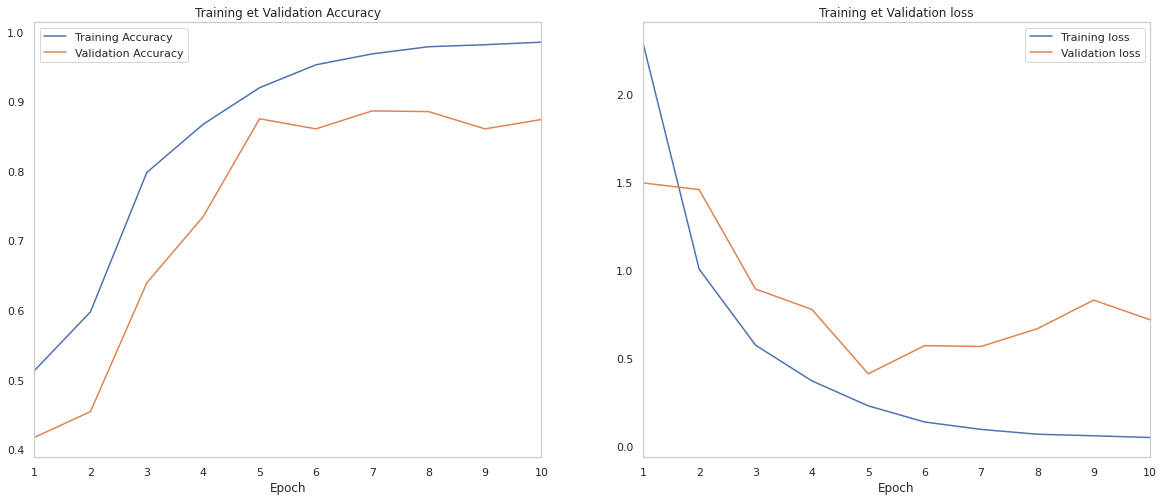

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

evaluate(model, y_pred, y_test, history, FOLDER_CNN)

## MODELISATION 2: LeNet

Cette modélisation utilise à une architecture basée sur "LeNet", un réseau de neurones convolutifs, caractérisé par une alternance de couches de convolution et de pooling, permettant l'extraction des caractéristiques des tomographies. La classification est assurée par une couche dense de réseaux de neurones connectés. More on [Here](https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg)


In [ ]:
model = Sequential()
model.add(Conv2D(filters = 30, kernel_size = (5, 5), input_shape=IMAGE_SHAPE, activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

### Résumé du modèle

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 252, 252, 30)      780       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 126, 126, 30)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 124, 124, 16)      4336      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

### Paramètrage de la métrique d'optimisation

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=6000, decay_rate=0.95, staircase=True)

### Compilation du modèle

In [ ]:
model.compile(optimizer=Adam(learning_rate = lr_schedule), loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [ ]:
epochs = 20
batch_size = 32
history = model.fit(X_train, y_train_categorial, validation_data=(X_test, y_test_categorial), epochs=epochs, batch_size=batch_size)

Epoch 1/20
2609/2609 [==============================] - 51s 19ms/step - loss: 1.8642 - accuracy: 0.4452 - val_loss: 1.5286 - val_accuracy: 0.2686
Epoch 2/20
2609/2609 [==============================] - 50s 19ms/step - loss: 1.2190 - accuracy: 0.4519 - val_loss: 1.5640 - val_accuracy: 0.2500
Epoch 3/20
2609/2609 [==============================] - 50s 19ms/step - loss: 1.2200 - accuracy: 0.4488 - val_loss: 1.5499 - val_accuracy: 0.2510
Epoch 4/20
2609/2609 [==============================] - 50s 19ms/step - loss: 1.2176 - accuracy: 0.4477 - val_loss: 1.5511 - val_accuracy: 0.2521
Epoch 5/20
2609/2609 [==============================] - 49s 19ms/step - loss: 1.2147 - accuracy: 0.4489 - val_loss: 1.5105 - val_accuracy: 0.2676
Epoch 6/20
2609/2609 [==============================] - 49s 19ms/step - loss: 1.2078 - accuracy: 0.4525 - val_loss: 1.5349 - val_accuracy: 0.2717
Epoch 7/20
2609/2609 [==============================] - 49s 19ms/step - loss: 1.1959 - accuracy: 0.4571 - val_loss: 1.5544 -

### Affichage et Export des résultats

              precision    recall  f1-score   support

         CNV       0.71      1.00      0.83       242
         DME       0.99      0.41      0.58       242
      DRUSEN       0.91      0.97      0.94       242
      NORMAL       0.89      0.98      0.93       242

    accuracy                           0.84       968
   macro avg       0.87      0.84      0.82       968
weighted avg       0.87      0.84      0.82       968

INFO:tensorflow:Assets written to: ././LeNet/assets


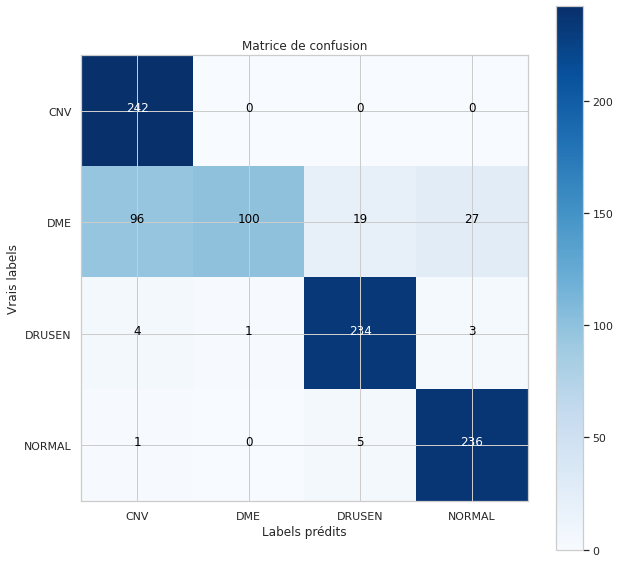

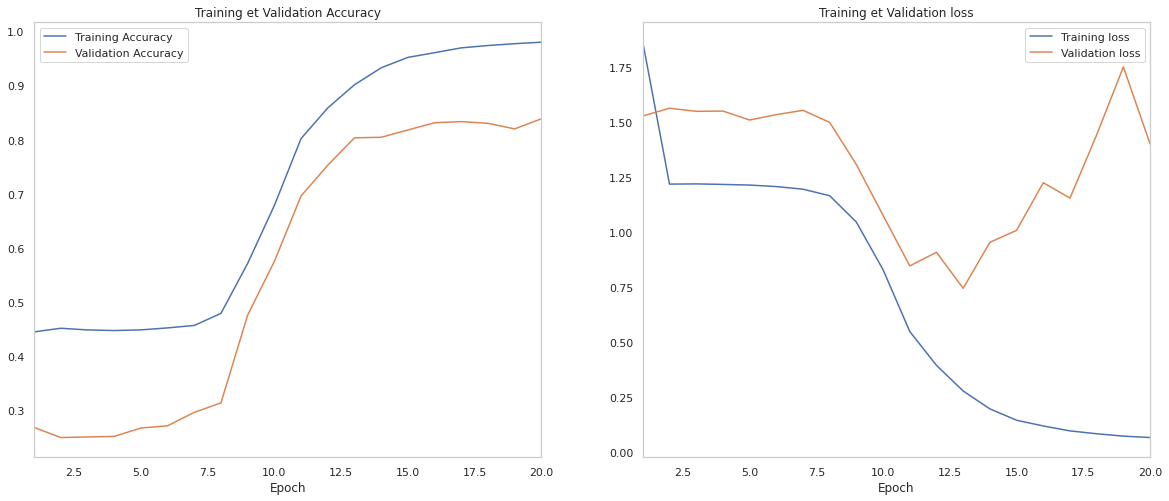

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

evaluate(model, y_pred, y_test, history, FOLDER_LE_NET)

## MODELISATION 3: Transfer Learning avec EfficientNetB5

Cette modélisation est basé sur le principe du transfer learning qui consiste à utiliser un modèle pré-entrainé sur des centaines de milliers d'image. Le modèle pré-entrainé choisi est EfficientNetB5, il permet l'extraction des caractéristiques des tomographies. La classification est assurée par une couche dense de réseau de neurones connectés. https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB5

In [ ]:
import tensorflow as tf
base_model=tf.keras.applications.EfficientNetB5(
    include_top=False, weights='imagenet', 
    input_shape=(256, 256, 3), pooling='avg', 
    classes=4, classifier_activation='softmax'
)

# Freezer les couches du modèle
for layer in base_model.layers:
    layer.trainable = False 

model=Sequential()
model.add(base_model)

model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(4, activation='softmax'))

### Résumé du modèle

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 2052      
Total params: 31,138,555
Trainable params: 2,625,028
Non-trainable params: 28,513,527
__________________________________

### Paramétrage de la métrique d'optimisation

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=6000, decay_rate=0.95, staircase=True)

### Compilation du modèle

In [ ]:
model.compile(optimizer=Adam(learning_rate = lr_schedule), loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [ ]:
print(f'X_train.shape=>{X_train.shape}')
print(f'X_test.shape=>{X_test.shape}')

X_train.shape=>(83484, 256, 256, 1)
X_test.shape=>(968, 256, 256, 1)


In [ ]:

X_train[0].shape

In [ ]:
epochs = 10
batch_size = 32
history = model.fit(X_train, y_train_categorial, validation_data=(X_test, y_test_categorial), epochs=epochs, batch_size=batch_size)

Epoch 1/10
2609/2609 [==============================] - 426s 157ms/step - loss: 0.4023 - accuracy: 0.8545 - val_loss: 0.2639 - val_accuracy: 0.8812
Epoch 2/10
2609/2609 [==============================] - 407s 156ms/step - loss: 0.3259 - accuracy: 0.8835 - val_loss: 0.1697 - val_accuracy: 0.9432
Epoch 3/10
2609/2609 [==============================] - 407s 156ms/step - loss: 0.3023 - accuracy: 0.8922 - val_loss: 0.1417 - val_accuracy: 0.9494
Epoch 4/10
2609/2609 [==============================] - 408s 156ms/step - loss: 0.2843 - accuracy: 0.8990 - val_loss: 0.1527 - val_accuracy: 0.9339
Epoch 5/10
2609/2609 [==============================] - 408s 156ms/step - loss: 0.2728 - accuracy: 0.9031 - val_loss: 0.1796 - val_accuracy: 0.9246
Epoch 6/10
2609/2609 [==============================] - 408s 156ms/step - loss: 0.2607 - accuracy: 0.9078 - val_loss: 0.1187 - val_accuracy: 0.9638
Epoch 7/10
2609/2609 [==============================] - 408s 156ms/step - loss: 0.2528 - accuracy: 0.9101 - val_

### Affichage et Export des résultats

              precision    recall  f1-score   support

         CNV       0.88      1.00      0.93       242
         DME       1.00      0.93      0.96       242
      DRUSEN       0.99      0.92      0.95       242
      NORMAL       0.99      1.00      0.99       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968

INFO:tensorflow:Assets written to: ././EfficientNetB5/assets


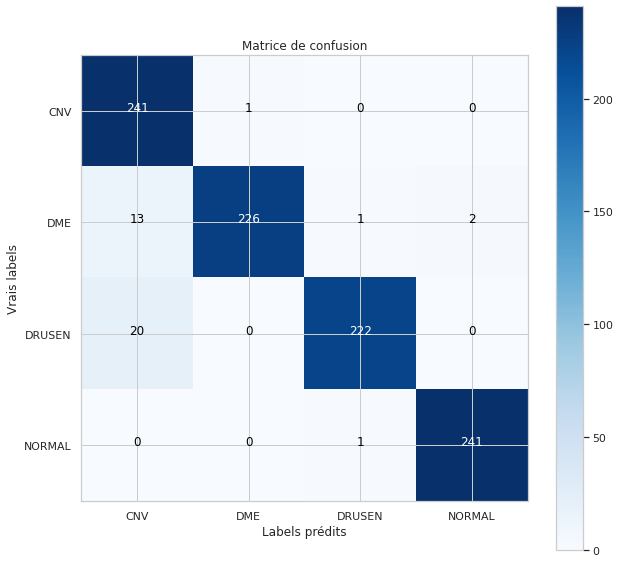

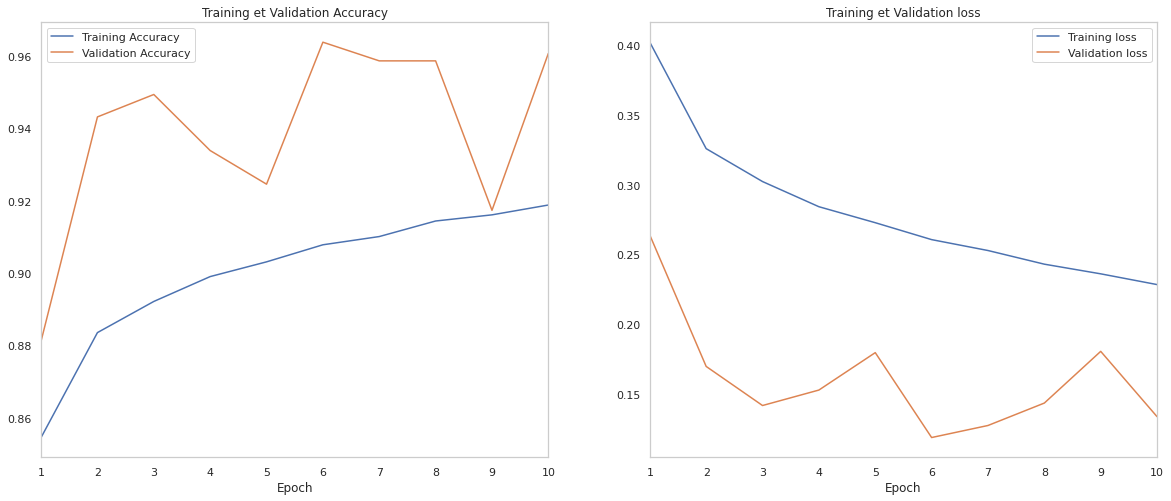

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

evaluate(model, y_pred, y_test, history, FOLDER_EFFICIENT_NET_B5)

## MODELISATION 4: VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
base_model=tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', 
    input_shape=(256, 256, 3), pooling='avg', 
    classes=4, classifier_activation='softmax'
)

# Freezer les couches du modèle
for layer in base_model.layers:
    layer.trainable = False 

model=Sequential()
model.add(base_model)

model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(4, activation='softmax'))

58892288/58889256 [==============================] - 1s 0us/step


### Résumé du modèle

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 15,766,852
Trainable params: 1,052,164
Non-trainable params: 14,714,688
____________________________________

### Paramétrage de la métrique d'optimisation

In [ ]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=6000, decay_rate=0.95, staircase=True)

### Compilation du modèle

In [ ]:
model.compile(optimizer=Adam(learning_rate = lr_schedule), loss = CategoricalCrossentropy(), metrics=['accuracy'])

### Entrainement du modèle

In [ ]:
epochs = 10
batch_size = 32


train_datagenerator = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagenerator.flow_from_directory('./OCT2017/train',
                                                          target_size = (256, 256), 
                                                          class_mode = 'categorical', 
                                                          batch_size = batch_size)




test_datagenerator = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagenerator.flow_from_directory('./OCT2017/test', 
                                                  target_size = (256, 256), 
                                                  class_mode = 'categorical', 
                                                  batch_size = batch_size)



history = model.fit(train_generator, epochs = epochs,validation_data = test_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Epoch 1/10
2609/2609 [==============================] - 411s 150ms/step - loss: 0.5060 - accuracy: 0.8133 - val_loss: 0.2739 - val_accuracy: 0.9101
Epoch 2/10
2609/2609 [==============================] - 352s 135ms/step - loss: 0.4068 - accuracy: 0.8500 - val_loss: 0.4000 - val_accuracy: 0.8192
Epoch 3/10
2609/2609 [==============================] - 340s 130ms/step - loss: 0.3786 - accuracy: 0.8612 - val_loss: 0.3159 - val_accuracy: 0.8874
Epoch 4/10
2609/2609 [==============================] - 338s 130ms/step - loss: 0.3629 - accuracy: 0.8669 - val_loss: 0.2627 - val_accuracy: 0.9101
Epoch 5/10
2609/2609 [==============================] - 337s 129ms/step - loss: 0.3495 - accuracy: 0.8717 - val_loss: 0.3193 - val_accuracy: 0.8688
Epoch 6/10
2609/2609 [==============================] - 336s 129ms/step - loss: 0.3442 - accuracy: 0.8740 - val_loss: 0.2147 - val_accuracy: 0.9298
Epoch 7/10
2609/2609 [======

### Affichage et Export des résultats

              precision    recall  f1-score   support

         CNV       0.25      0.29      0.27       242
         DME       0.25      0.21      0.23       242
      DRUSEN       0.27      0.25      0.26       242
      NORMAL       0.28      0.30      0.29       242

    accuracy                           0.26       968
   macro avg       0.26      0.26      0.26       968
weighted avg       0.26      0.26      0.26       968

INFO:tensorflow:Assets written to: ././VGG16/assets


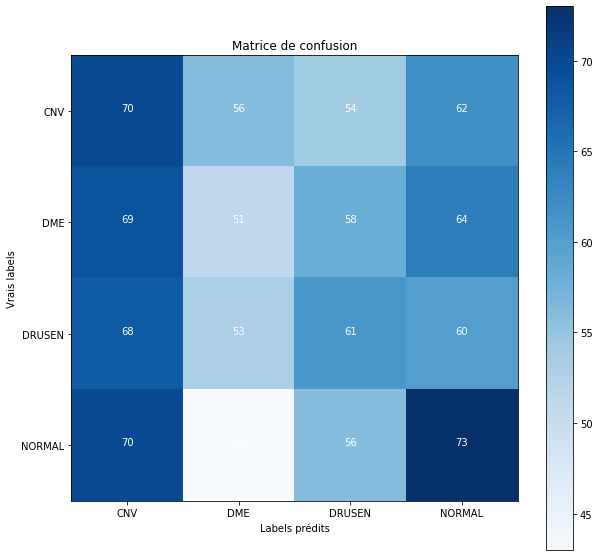

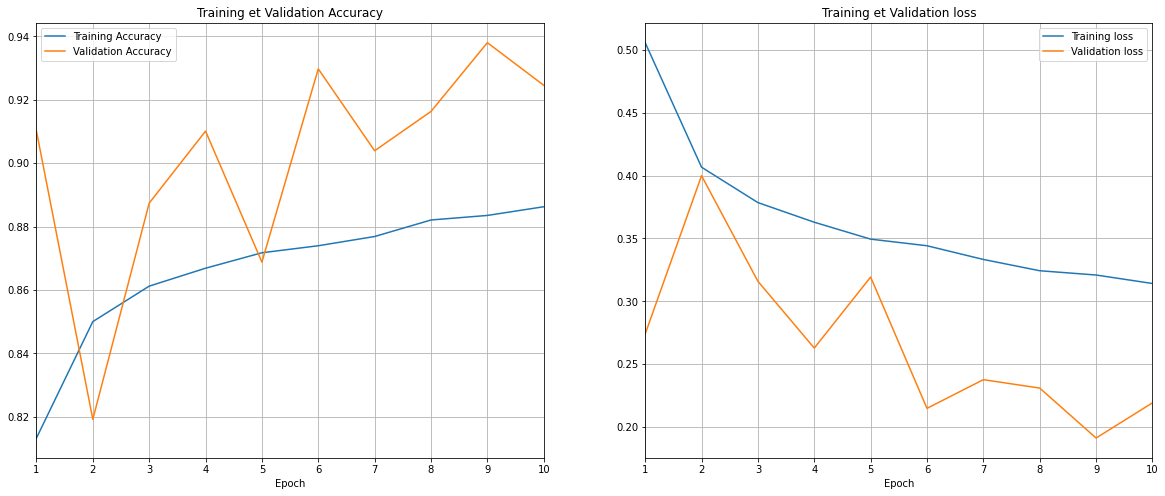

In [ ]:
y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_categorial, axis=1)

evaluate(model, y_pred, y_test, history, FOLDER_VGG16)

# Exporter les modèles au format Zip

In [ ]:
from shutil import make_archive
for folder in FOLDERS:
  make_archive(folder,'zip', root_dir=f'{folder}')

In [ ]:
# Export validation datset for Demo
make_archive('OCT2017-VAL','zip', root_dir='./OCT2017/val/')

'/content/OCT2017-VAL.zip'

In [ ]:
make_archive('./VGG16','zip', root_dir=f'./VGG16')

'/content/VGG16.zip'